# A Hybrid Learning Approach to Synthetic Position Construction for Tax Loss Harvesting

# Generation of Synthetic Positions Using Hybrid Learning

In [182]:
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


corr_matrix_file_path = "pickles/corr_matrix.obj"
x_labels_file_path = "pickles/X_labels.obj"
sptm_comp_file_path = "pickles/sptm_composition.obj"
sptm_price_file_path = "pickles/sptm_price.obj"

In [49]:
# Composition data from pickle
sptm_comp_file = open(sptm_comp_file_path, 'rb')
sptm_composition = pickle.load(sptm_comp_file)
sptm_comp_file.close()

# Price history downloaded from Yahoo Finance and stored in pickle
sptm_price_file = open(sptm_price_file_path, 'rb')
sptm_price_history = pickle.load(sptm_price_file)
sptm_price_file.close()

all_tickers = sptm_composition.keys()

# Gets a list of all valid trading dates
all_dates = sptm_price_history[list(all_tickers)[0]].axes[0].values
dates = pd.DatetimeIndex(data=all_dates)
current_date = all_dates[0]

### Finding Highly Correlated Stocks
#### Use the *do_corr_matrix_regen* variable to tell the code to generate the correlation matrix, else it will load it from a pickle

In [211]:
do_corr_matrix_regen = False

In [51]:
# Data Range: 2015-01-02 - 2021-12-30
# Training Range: 2015-01-02 - 2020-01-02
# Validation Range: 2020-01-03 - 2021-01-02
# Testing Range: 2021-01-03 - 2021-12-31

num_stocks = len(all_tickers)


def regenerate_corr_matrix(days=60):
    """Calculates the correlation between every stock's percent time series
    :param days: How many days of price history should be used to calculate the correlation matrix (default = 60)
    """
    x = []
    x_labels = []

    for ticker in all_tickers:
        x.append(sptm_price_history[ticker].Close.pct_change().iloc[len(sptm_price_history[ticker].Close) - days:])
        x_labels.append(ticker)

    correlation_matrix = [[0 for _ in range(0, num_stocks)] for _ in range(0, num_stocks)]

    for l in range(0, num_stocks):
        for m in range(0, num_stocks):
            correlation_matrix[l][m] = x[l].corr(x[m])
    correlation_matrix = pd.DataFrame(correlation_matrix, columns=x_labels[0:num_stocks])

    correlation_matrix_file = open(corr_matrix_file_path, 'wb')
    pickle.dump(correlation_matrix, correlation_matrix_file)
    correlation_matrix_file.close()

    x_labels_file = open(x_labels_file_path, 'wb')
    pickle.dump(x_labels, x_labels_file)
    x_labels_file.close()


def load_corr_matrix():
    """Loads correlation matrix and labels from pickles
    :returns: [correlation_matrix, x_labels]
    """
    # Covariance Matrix from pickle
    corr_matrix_file = open(corr_matrix_file_path, 'rb')
    correlation_matrix = pickle.load(corr_matrix_file)
    corr_matrix_file.close()

    # X_Labels from pickle
    x_labels_file = open(x_labels_file_path, 'rb')
    x_labels = pickle.load(x_labels_file)
    x_labels_file.close()

    return correlation_matrix, x_labels


if do_corr_matrix_regen:
    regenerate_corr_matrix(days=60)

corr_matrix, X_labels = load_corr_matrix()

In [112]:
def filter_substantially_similar_securities(ticker, series, additional_stocks=None):
    """Filters out the stocks you cannot buy because of a wash sale
    :param series: The series of correlated stocks that should be filtered
    :param ticker: Ticker to filter out securities for
    :param additional_stocks: Any additional stocks you want to filter out (default = None)
    """
    if additional_stocks is None:
        additional_stocks = []

    # Handles Google having both GOOG and GOOGL in the dataset
    if ticker == "GOOG" or ticker:
        additional_stocks.append("GOOG")
        additional_stocks.append("GOOGL")

    additional_stocks.append(ticker)

    return series.drop(additional_stocks)


def find_top_correlated_stocks(ticker, n=10):
    """Finds the top n stocks correlated with a given stock
    :param n: the number of correlated stock to return (default = 10)
    :param ticker: The ticker for which correlated stocks should be found
    :returns: A list (sorted by most correlation) of correlated stocks
    """
    index = X_labels.index(ticker)

    correlated_stocks = corr_matrix.iloc[index].sort_values(ascending=False, key=abs)
    filtered_correlations = filter_substantially_similar_securities(ticker, correlated_stocks)

    return filtered_correlations.iloc[:n]

### Principle Component Analysis

In [295]:
def get_price_histories_dataframe(stocks, target_stock):
    """Compiles a DataFrame with the price histories of the specified stocks
    :param target_stock: The stock for which the dataset should be created
    :param stocks: The stocks to include in the DataFrame
    :returns: (Features DataFrame, Target DataFrame)"""
    d = {}
    for correlated_stock in stocks:
        d[correlated_stock] = sptm_price_history[correlated_stock].Close.values
    target = pd.DataFrame({target_stock: sptm_price_history[target_stock].Close.values})
    return pd.DataFrame(data = d), target

def get_datasets(target_stock, n=10):
    """Compiles the necessary datasets for PCA. One with the price history of the features, and one with the price history of the target
    :param target_stock: The stock for which the dataset should be created
    :returns: (x, y) where x and y are DataFrames
    """
    corr_stocks = find_top_correlated_stocks(target_stock, n).keys().values
    return get_price_histories_dataframe(corr_stocks,target_stock)

x,y = get_datasets('AAPL', 10)

print(x)

LRCX
            LRCX         TXN       FORM       RMBS       CRUS       ACLS  \
0      70.975533   43.957123   8.310000  11.460000  23.709999  10.200000   
1      70.109001   43.274929   8.450000  11.140000  23.330000  10.000000   
2      68.938728   42.559826   8.010000  10.840000  22.910000   9.600000   
3      69.296066   43.324238   8.130000  10.920000  23.080000   9.720000   
4      71.091675   44.031090   8.450000  11.020000  23.440001   9.920000   
...          ...         ...        ...        ...        ...        ...   
1758  721.086426  189.290878  45.930000  29.680000  93.180000  72.839996   
1759  713.809692  188.560730  45.250000  29.250000  92.339996  71.419998   
1760  724.425659  188.274567  46.040001  29.459999  92.430000  73.360001   
1761  716.032593  186.893188  45.570000  29.030001  91.940002  73.110001   
1762  716.849976  185.965668  45.720001  29.389999  92.019997  74.559998   

            NXPI        MSFT       TRMB        AVGO  
0      73.321777   41.013309

In [244]:
# Standardize the features
X = StandardScaler().fit_transform(x)

In [316]:
number_components = 1
pca = PCA(n_components=number_components) # TODO validate this
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns=["PC "+ str(i) for i in range (0, number_components)])
finalDf = pd.concat([principalDf, y], axis = 1)
model = sm.OLS(principalDf, y).fit()
print(model.params)

loadings = pd.DataFrame(pca.components_.T, index=x.columns)
# print(loadings)
#print(pca.explained_variance_ratio_)
# print(pca.singular_values_)
#print(model.pvalues)

synthetic_position = {}
print()
print(loadings[0].index.values)

for pc in range(0, number_components):
    for c_stock in loadings[pc].index.values:
        synthetic_position[c_stock]= loadings[pc][c_stock]
print()
print(synthetic_position)

AAPL    0.022524
dtype: float64

['LRCX' 'TXN' 'FORM' 'RMBS' 'CRUS' 'ACLS' 'NXPI' 'MSFT' 'TRMB' 'AVGO']

{'LRCX': 0.3297284300862019, 'TXN': 0.32110963767185785, 'FORM': 0.320409893229997, 'RMBS': 0.293994849165193, 'CRUS': 0.29031934710909757, 'ACLS': 0.31123502432367284, 'NXPI': 0.3204385334187646, 'MSFT': 0.3204587284001481, 'TRMB': 0.32477279820509364, 'AVGO': 0.32721202230179186}


In [269]:
def hybrid_learning_replace(ticker) -> {}:
    """Determines which stocks to buy to emulate the performance of another
    :param ticker: The stock for which a synthetic position should be calculated
    :returns: Dictionary of replacement tickers and their quantities
    """
    print(ticker)
    return {}
    #TODO

# Stock Market Backtester

If you want to run this simulator with different stocks and/or generate a new starting portfolio, do the following:
1. Create a CSV file with the format: Ticker, Quantity
2. Run **csvToComp.py** to generate text you can paste in as the *snp_composition* variable in **compToPickle.py**
3. Run **compToPickle.py**
4. Adjust the date range in **yfToPickle.py**
5. Run **yfToPickle.py**, which will take a while, since it is downloading all of the price histories from Yahoo Finance

In [257]:
import pandas as pd
import pyfolio as pf  #install using  pip3 install git+https://github.com/quantopian/pyfolio
from enum import Enum
import warnings
import pickle
%matplotlib inline

snp_comp_file_path = "pickles/snp_composition.obj"
snp_price_file_path = "pickles/snp_price.obj"

In [264]:
# Composition data from pickle
snp_comp_file = open(snp_comp_file_path, 'rb')
snp_composition = pickle.load(snp_comp_file)
snp_comp_file.close()

# Price history downloaded from Yahoo Finance and stored in pickle
snp_price_file = open(sptm_price_file_path, 'rb')
price_history = pickle.load(snp_price_file)
snp_price_file.close()

all_tickers = snp_composition.keys()

# Gets a list of all valid trading dates
all_dates = price_history[list(all_tickers)[0]].axes[0].values
dates = pd.DatetimeIndex(data=all_dates)
current_date = all_dates[0]

In [300]:
def get_stock_price(ticker, day, time) -> float:
    """Retrieves the closing price of a stock on a given date
    :param ticker: stock for which to retrieve the value
    :param day: date on which to retrieve the value
    :param time of day to calculate the value, either Time.OPEN or Time.CLOSE
    """
    if time == Time.OPEN:
        return round(price_history[ticker].Open[day], 2)
    elif time == Time.CLOSE:
        return round(price_history[ticker].Close[day], 2)


class Time(Enum):
    OPEN = 0
    CLOSE = 1


class Stock:
    def __init__(self, ticker, quantity=0):
        """Creates an object representing an owned stock
        :param ticker: The stock's ticker symbol
        :param quantity: How much of this stock is owned (this should only be used when constructing initial stock portfolios, as it essentially creates stock for free)
        """
        self.ticker = ticker
        self.quantity = quantity
        self.avg_cost = get_stock_price(self.ticker, current_date, Time.CLOSE)

    def buy(self, quantity, day_price):
        """Simulates a portfolio acquiring new stock
        :param quantity: The amount of new stock to acquire
        :param day_price: The price of the stock on the day of acquisition
        """
        previously_owned = self.quantity
        self.quantity += quantity
        self.avg_cost += (previously_owned * self.avg_cost + quantity * day_price) / self.quantity

    def sell(self, quantity, day_price):
        """Simulates a portfolio selling a stock
        :param quantity: The amount of new stock to sell
        :param day_price: The price of the stock on the day of acquisition
        """
        previously_owned = self.quantity
        self.quantity -= quantity
        self.avg_cost -= (previously_owned * self.avg_cost - quantity * day_price) / self.quantity

    def sell_all(self):
        """Simulates selling all of a stock
        """
        self.quantity = 0
        self.avg_cost = 0

    def get_pct_change(self):
        """Gets the percent change of the stock based on the average cost
        """
        change = self.get_change()
        return 100 * (change / self.avg_cost)

    def get_change(self) -> float:
        """Gets the difference between the stock's average purchase price and its current price
        :returns: float
        """
        current_price = get_stock_price(self.ticker, current_date, Time.CLOSE)
        return current_price - self.avg_cost


class Portfolio:
    def __init__(self, starting_cash_balance: float = 1000000, starting_stocks=None):
        """Creates a new portfolio
        :param starting_cash_balance: The amount of cash the portfolio should start with (default 100,000.0)
        :param starting_stocks: A dictionary containing the stocks the portfolio should begin with {'Ticker': Stock Object} (default is no starting stocks)
        """
        if starting_stocks is None:
            starting_stocks = {}
        self.stocks = starting_stocks
        self.cash_balance = starting_cash_balance
        self.value = 0
        self.calculate_value(Time.CLOSE)
        self.closing_prices = []
        self.returns = None
        self.wash_sale_list = {}

    def calculate_value(self, time):
        """Calculates the value of the portfolio based on the close of the global current date
        :param time of day to calculate the value, either Time.OPEN or Time.CLOSE
        """
        self.calculate_value_date(current_date, time)

    def calculate_value_date(self, day, time):
        """Calculates the value of the portfolio based on a specified date
        :param day: the date on which the portfolio's value should be calculated
        :param time of day to calculate the value, either Time.OPEN or Time.CLOSE
        """
        self.value = self.cash_balance
        for stock in self.stocks.keys():
            self.value += get_stock_price(stock, day, time) * self.stocks[stock].quantity

    def update_wash_sale_list(self):
        """Increments the counter for every item in the wash sale list and removes an item if the counter is >30
        """
        remove_from_list = []
        for wash_stock in self.wash_sale_list.keys():
            self.wash_sale_list[wash_stock] += 1
            if self.wash_sale_list[wash_stock] > 30:
                remove_from_list.append(wash_stock)

        for to_remove in remove_from_list:
            self.wash_sale_list.pop(to_remove)

    def begin_day(self):
        """Calculates the starting value of the day and updates the wash sale list"""
        self.calculate_value(Time.CLOSE)
        self.update_wash_sale_list()

    def end_day(self):
        """"Calculates the day's closing value and adds it to a list
        """
        self.calculate_value(Time.CLOSE)
        self.closing_prices.append(self.value)

    def end_simulation(self):
        """Creates a Pandas Series of percent change of closing values and returns it
        """
        self.returns = pd.Series(data=self.closing_prices, index=dates[len(dates)-60:]).pct_change() #TODO delete [len(dates)-60:]
        return self.returns

    def does_own_stock(self, ticker) -> bool:
        """Reports whether this portfolio contains a given stock
        :param ticker: The stock to search for
        """
        return ticker in self.stocks.keys()

    def buy_stock(self, ticker, quantity):
        """Buys stock using cash balance if possible
        :param ticker: The stock to purchase
        :param quantity: The quantity of the stock to purchase (can be a float)
        """
        stock_price = get_stock_price(ticker, current_date, Time.CLOSE)
        trade_basis = stock_price * quantity  #TODO can add fees here

        # Exit if we cannot complete the trade
        if trade_basis > self.cash_balance:
            warnings.warn("Not enough cash to execute trade: buy " + str(quantity) + " " + ticker)
            return

        if ticker in self.wash_sale_list:
            warnings.warn("Cannot buy " + ticker + ": wash sale violation")
            return

        # If we do not currently own the stock, create an entry
        if ticker not in self.stocks.keys():
            self.stocks[ticker] = Stock(ticker)

        # Execute the trade
        self.stocks[ticker].buy(quantity, stock_price)
        self.cash_balance -= trade_basis

    def sell_stock(self, ticker, quantity=0, sell_all=False):
        """Sells stock and adds to cash balance
        :param ticker: The stock to sell
        :param quantity: The quantity of the stock to sell (can be a float)
        :param sell_all: Optional parameter to sell all stock
        """
        stock_price = get_stock_price(ticker, current_date, Time.CLOSE)
        # Ensure we have enough stock to sell
        quantity_owned = self.stocks[ticker].quantity
        if quantity > quantity_owned:
            return

        if sell_all or quantity == quantity_owned:
            self.stocks[ticker].sell_all()
            self.cash_balance += quantity_owned * stock_price
            self.stocks.pop(ticker)

            # Update the wash sale list
            self.wash_sale_list[ticker] = 0
            return

        # Do the trade
        self.stocks[ticker].sell()
        self.cash_balance += quantity * stock_price  #TODO maybe things should be added to the wash sale list even if we just sell partial (but in theory we are always doing sellall)

    def identify_losers(self):
        """Identifies stocks that have dropped in value more than 5% since they were bought
        :returns: List of all stocks that have dropped more than 5%
        """
        identified_losers = []
        for owned_stock in self.stocks.keys():
            if self.stocks[owned_stock].get_change() <= -1 * (0.05 * self.value):
                identified_losers.append(owned_stock)
        return identified_losers

In [318]:
initial_stocks = {}

# for comp_stock in snp_composition:
#     initial_stocks[comp_stock] = Stock(comp_stock, snp_composition[comp_stock])



aapl_clone = {'LRCX': 0.3297284300862019, 'TXN': 0.32110963767185785, 'FORM': 0.320409893229997, 'RMBS': 0.293994849165193, 'CRUS': 0.29031934710909757, 'ACLS': 0.31123502432367284, 'NXPI': 0.3204385334187646, 'MSFT': 0.3204587284001481, 'TRMB': 0.32477279820509364, 'AVGO': 0.32721202230179186}

for a_stock in aapl_clone.keys():
    initial_stocks[a_stock] = Stock(a_stock, aapl_clone[a_stock])

#initial_stocks['AAPL'] = Stock('AAPL', 1)
#initial_stocks['LRCX'] = Stock('LRCX', 1)

In [319]:
# The hybrid learning portfolio
h_l_portfolio = Portfolio(0,
                          initial_stocks)
print(all_dates[0])

for date in range(len(all_dates)-60, len(all_dates)):
    # update the current day
    current_date = date

    # Allow the portfolio to perform start of day updates
    h_l_portfolio.begin_day()

    # Determine which stocks should be tax loss harvested
    losers = h_l_portfolio.identify_losers()

    # for losing_stock in losers:
    #     # Get dictionary of replacement stocks {'Ticker': Quantity}
    #     replacement_stocks = hybrid_learning_replace(losing_stock)
    #
    #     # Sell the losing stock
    #     h_l_portfolio.sell_stock(losing_stock, sell_all=True)
    #
    #     # Buy the replacement stocks
    #     for buy_stock in replacement_stocks.keys():
    #         h_l_portfolio.buy_stock(buy_stock, replacement_stocks[buy_stock])

    # Allow the portfolio to perform end-of-day updates
    h_l_portfolio.end_day()

# Inform the portfolio that the simulation has ended
returns = h_l_portfolio.end_simulation()

2015-01-02T00:00:00.000000000


In [328]:
AAPLRets = sptm_price_history['AAPL'].iloc[len(sptm_price_history)-60:].Close.pct_change()
LRCXRets= sptm_price_history['LRCX'].iloc[len(sptm_price_history)-60:].Close.pct_change()

print("First Correlated Stock Returns")
print(LRCXRets.corr(AAPLRets))

print("\nSynthetic Returns")
print(returns.corr(AAPLRets))

# TODO make it so the model only trains on dates during the test era, so I can evaluate performance during a real unseen period

First Correlated Stock Returns
0.6251982757723163

Synthetic Returns
0.7583026946954813


/Users/nikhil/Documents/Finance Research/A-Hybrid-Learning-Approach-to-Generating-Synthetic-Positions-for-Tax-Loss-Harvesting/venv/lib/python3.10/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2021-10-07
End date,2021-12-31
Total months,2
,Backtest
Annual return,143.167%
Cumulative returns,23.561%
Annual volatility,23.997%
Sharpe ratio,3.89
Calmar ratio,39.31
Stability,0.95
Max drawdown,-3.642%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3.64,2021-12-10,2021-12-16,2021-12-23,10
1,2.82,2021-11-19,2021-11-26,2021-11-29,7
2,2.21,2021-10-07,2021-10-13,2021-10-14,6
3,2.14,2021-11-09,2021-11-10,2021-11-12,4
4,1.90,2021-11-29,2021-12-03,2021-12-07,7


/Users/nikhil/Documents/Finance Research/A-Hybrid-Learning-Approach-to-Generating-Synthetic-Positions-for-Tax-Loss-Harvesting/venv/lib/python3.10/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/nikhil/Documents/Finance Research/A-Hybrid-Learning-Approach-to-Generating-Synthetic-Positions-for-Tax-Loss-Harvesting/venv/lib/python3.10/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/nikhil/Documents/Finance Research/A-Hybrid-Learning-Approach-to-Generating-Synthetic-Positions-for-Tax-Loss-Harvesting/venv/lib/python3.10/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will 

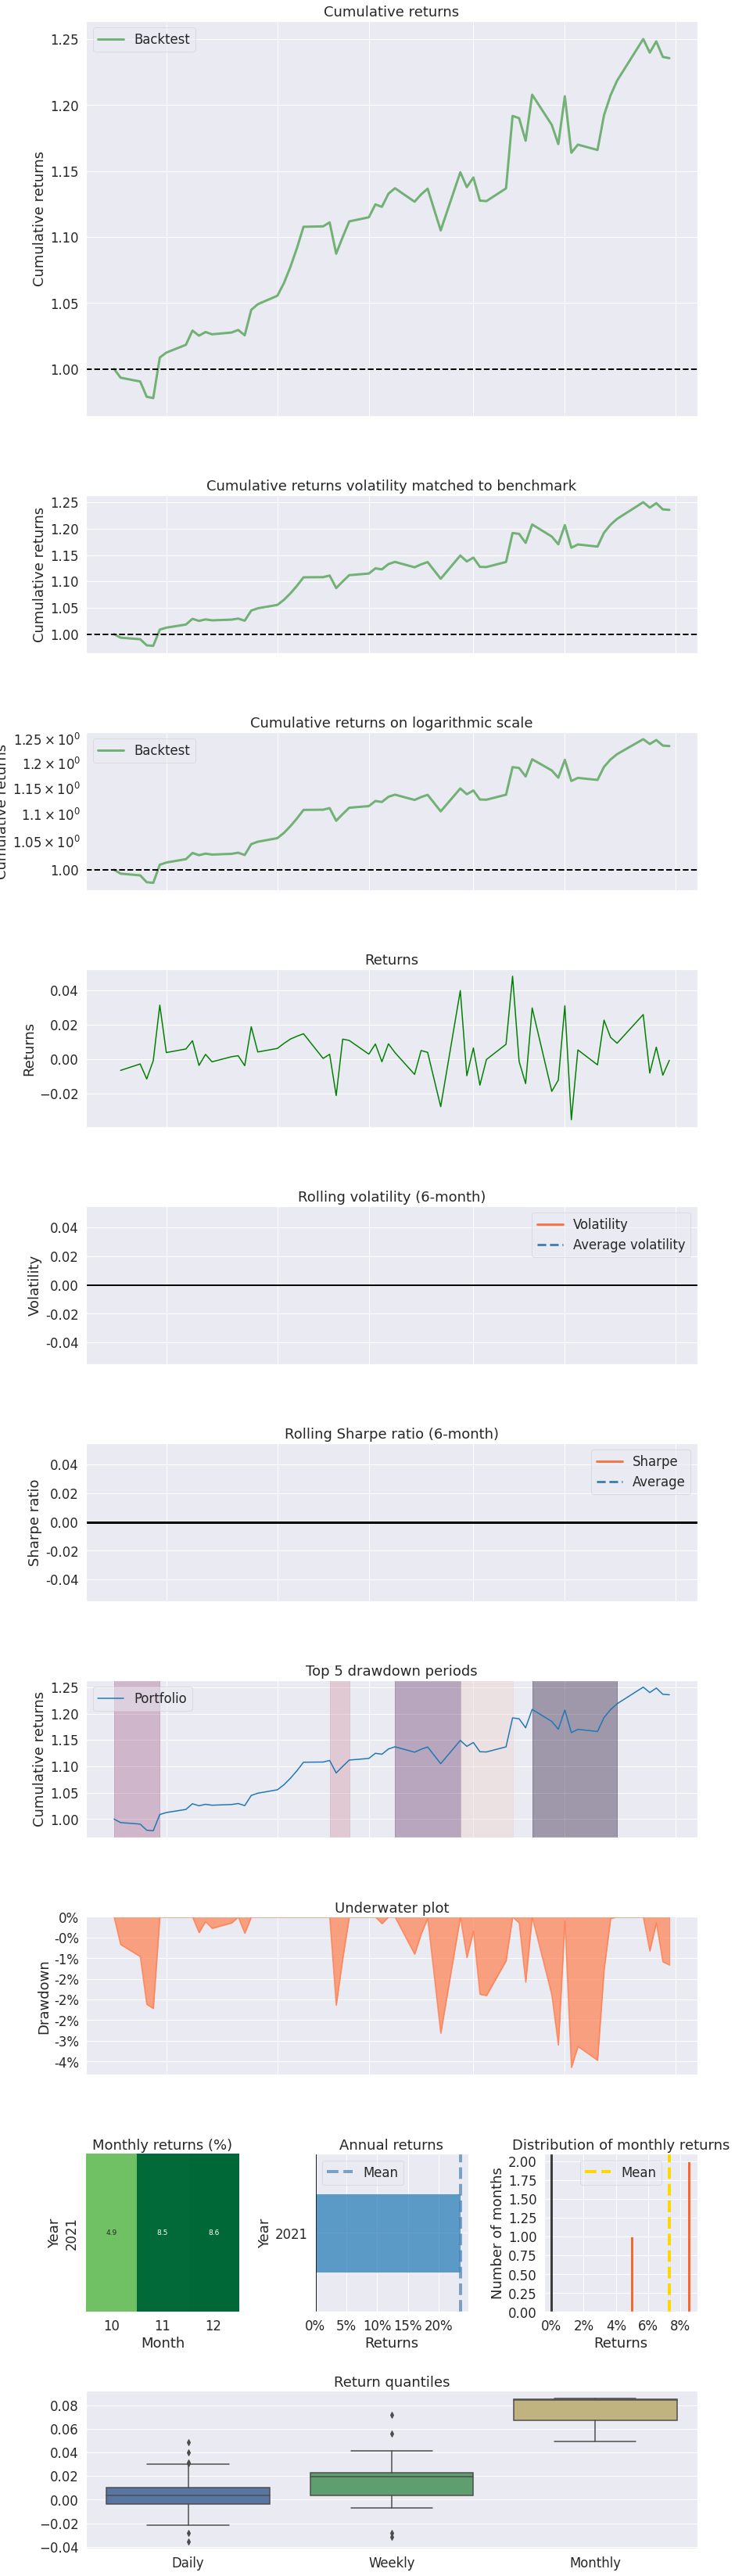

In [320]:
pf.create_returns_tear_sheet(returns)